In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, make_scorer, roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, validation_curve, HalvingRandomSearchCV
import scipy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = load_breast_cancer(as_frame=True)
df = pd.DataFrame(df.frame)
df.columns


X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
# le = LabelEncoder()
# y = le.fit_transform(y)
# le.classes_
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [3]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.956


In [4]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    print(train, test)
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(
        f"Fold: {k + 1:02d},\n Class distr: {np.bincount(y_train[train])}, \n Acc: {score:.3f}"
    )

[ 43  45  46  47  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 29

## The standard deviation
measures how spread out the values are from their mean value. A low standard deviation indicates that the values tend to be close to the mean, while a high standard deviation indicates that the values are
more spread out.

**Standard Deviation Notation**

In statistics, the notation `+/-` is commonly used to indicate the range of values within one standard deviation of the mean. In this context, it means:

* The average accuracy score (CV accuracy) is 0.950.
* There is a significant amount of variability in the scores, with some being as low as 0.933 (1 standard deviation below the mean) and others being as high as 0.977 (1 standard deviation above the mean).

In other words, if you were to take any average model that achieved an accuracy score close to 0.950 (e.g., 0.948 or 0.952), it's likely that this model would perform similarly well to our estimated best performer.

To illustrate this, here are some examples of how the notation `+/-` can be interpreted:

* `CV accuracy: 0.950 +/- 0.014`: This means that if you were to use a different model or tweak your hyperparameters, there's a good chance the accuracy would fall within this range (i.e., between 0.936 and 0.964).
* For comparison, if we had a simple thresholding approach with an accuracy of exactly 0.95, it might overfit slightly to the training data.

By using `+/-`, you get a sense of how robust your results are and whether they're likely due to chance or actual differences between models.

**Interpretation of Standard Deviation Values**

When looking at the standard deviation values, you can follow these rough guidelines:

* Low values (< 0.05): The accuracy is very consistent across folds, suggesting a good model with minimal overfitting.
* Medium values (0.05-0.10): There's some variability in the scores, indicating that the model might be slightly overfitting or underfitting, but it's still within an acceptable range.
* High values (> 0.10): The accuracy is quite variable across folds, suggesting significant overfitting or underfitting.

In [5]:
# Alternative way with scikit-learn
# when n_jobs is set to -1 it will use all available cores on the machine
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(f"CV accuracy scores: {scores}")
print(f"CV accuracy: {np.mean(scores):.3f}, \n +/- {np.std(scores):.3f}")

CV accuracy scores: [0.97826087 0.93478261 0.95652174 0.93478261 0.91304348 0.95555556
 0.93333333 0.95555556 0.93333333 0.97777778]
CV accuracy: 0.947, 
 +/- 0.020


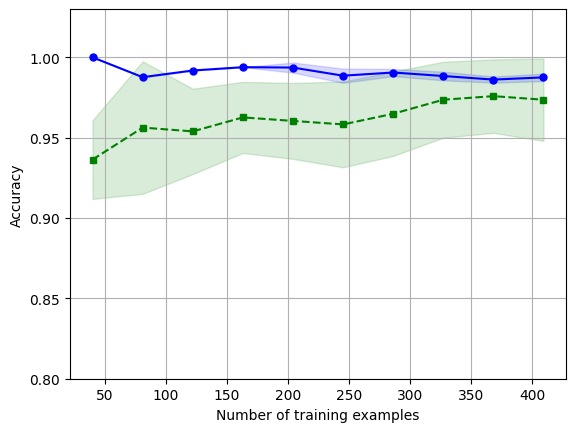

In [6]:
# Learning curve
pipe_lr = make_pipeline(
StandardScaler(), LogisticRegression(penalty="l2", max_iter=10000)
)
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1.0,10), cv=10, n_jobs=-1)

# This one is the accuracy
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label="Training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, linestyle='--' ,label="Validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.03])
plt.show();

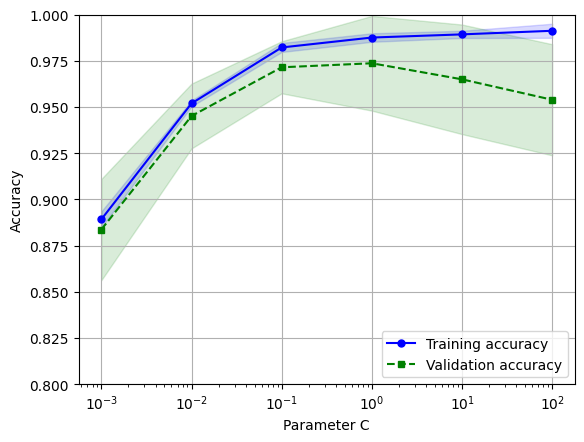

In [7]:
param_range =  [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)

# This one is the accuracy
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label="Training accuracy")
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--' ,label="Validation accuracy")
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.00])
plt.show();
# Best choice might be 0.1

In [8]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# NOTE: when you set the refit to true which by default is set to true, in fact there is no need to fit the best estimator model again on the data since it
# has been done already bythe gridsearch, it's just extra computation if you do
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
clf = gs.best_estimator_
print(f'Test accuracy of best estimator (GridSearchCV): {clf.score(X_test, y_test):.3f}')

0.9758454106280192
{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy of best estimator (GridSearchCV): 0.982


In [9]:
## RandomizedSearch
param_range = scipy.stats.loguniform(0.0001, 1000.0)
# To reproduce the same results
np.random.seed(1)
param_range.rvs(10)
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid, scoring='accuracy', refit=True, n_iter=20, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)
print(f'Test accuracy of best estimator (RandomizedSearchCV): {rs.score(X_test, y_test):.3f}')

0.9758454106280192
{'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}
Test accuracy of best estimator (RandomizedSearchCV): 0.982


In [10]:
# HalvingRandomSearch (better than RandomSearch)
hs = HalvingRandomSearchCV(pipe_svc, param_distributions=param_grid, n_candidates='exhaust', resource='n_samples', factor=1.5, random_state=1, n_jobs=-1)
hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)
print(f"Test accuracy of best estimator (HalvingRandomSearchCV): {hs.score(X_test, y_test):.3f}")

0.973529411764706
{'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}
Test accuracy of best estimator (HalvingRandomSearchCV): 0.982


In [11]:
# Nested cross-validation with GridSearchCV
param_range = [0.0001, 0.001, 0.01, 0.1, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
# With SVM
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f"CV accuracy: {np.mean(scores):.3f}, \n +/- {np.std(scores):.3f}")
# With Decision trees (In order to compare which algorithm perform better on this dataset) 
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}], scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f"CV accuracy: {np.mean(scores):.3f}, \n +/- {np.std(scores):.3f}")
# Obviously SVM achieved better scores

CV accuracy: 0.971, 
 +/- 0.011


CV accuracy: 0.932, 
 +/- 0.013


[[40  2]
 [ 0 72]]


Text(0, 0.5, 'True label')

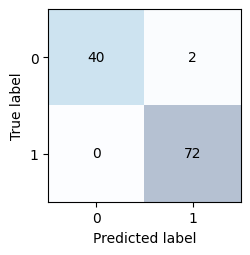

In [12]:
# Performance evaluation metrics
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5,2.5))
# ax.matshow(confmat)
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [13]:
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'Precission: {pre_val:.3f}')
print(f'Recall: {rec_val:.3f}')
print(f'F1: {f1_val:.3f}')
print(f'MCC: {mcc_val:.3f}')



Precission: 0.973
Recall: 1.000
F1: 0.986
MCC: 0.963


In [14]:
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']}, {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]
# NOTE: pos_label should be set to the class that represents the event of interest, not the numerically larger label or the default 1.
scorer = make_scorer(f1_score, pos_label=1)
# To use defined scorer with make_scorer (instead of accuracy)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, refit=True)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9774780170765898
{'svc__C': 10.0, 'svc__kernel': 'linear'}


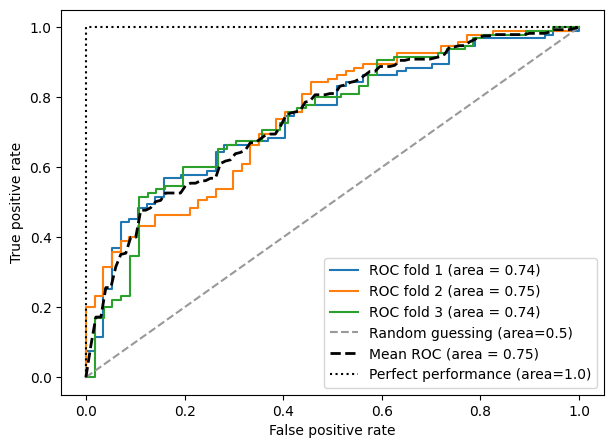

In [15]:
# ROC Curve
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=10.0, solver='lbfgs'))
X_train2 = X_train[:, [4,14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train,y_train))
fig= plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1, 100)
all_tpr = []
for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
[0, 1, 1],
linestyle=':',
color='black',
label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Imbalanced data
# creating some imbalanced data
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

# What it's trying to say is that if we predict 0 40 times (or always), we might achieve 84% accuracy since we predicted all classes as 0 ! this is a imbalanced prediction
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

84.12698412698413

In [17]:
# Handling imbalanced data
print("Number of class 1 exampels before:", X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)
print("Number of class 1 examples after:", X_upsampled.shape[0])
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
# The accuracy is changed to 50 so that it's reasonable
np.mean(y_pred == y_bal) * 100

Number of class 1 exampels before: 40
Number of class 1 examples after: 212


50.0